In [44]:
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.fft as sp_fft
import scipy.signal as sp_sig
from cjte import calculate_cjte
from te import transfer_entropy

In [45]:
def calculate_fundamental_component(signal: np.array, fs: float, low_f=0.66, high_f=3) -> tuple[float, float]:
    """
    Calculates fundamental component of signal in given frequency range
    :param signal: signal
    :param fs: sampling frequency
    :param low_f: lower frequency range
    :param high_f: higher frequency range
    :return: fundamental frequency and its amplitude
    """
    n_fft = len(signal)
    win_fft_amp = sp_fft.rfft(sp_sig.detrend(signal) * sp_sig.windows.hann(n_fft), n=n_fft)
    corr_factor = n_fft / np.sum(sp_sig.windows.hann(n_fft))
    win_fft_amp = abs(win_fft_amp) * 2 / n_fft * corr_factor

    win_fft_f = sp_fft.rfftfreq(n_fft, d=1 / fs)
    f_low = int(low_f * n_fft / fs)
    f_upp = int(high_f * n_fft / fs)
    win_fft_amp_range = win_fft_amp[f_low:f_upp]
    fund_idx = np.argmax(win_fft_amp_range) + f_low

    fund_f = win_fft_f[fund_idx]
    fund_amp = win_fft_amp[fund_idx]
    return fund_f, fund_amp


def calculate_mean_HR(signal: np.array, fs: float = 200) -> float:
    """
    Calculates mean HR from abp signal
    :param signal: abp signal
    :param fs: sampling frequency
    """
    c_f1, amp_abp = calculate_fundamental_component(signal, fs)
    HR = c_f1 * 60
    return HR

In [46]:
def find_peaks(
    signal: np.array,
    sampling_rate: int = 200,
    mindelay: float = 0.3,
) -> np.array:
    # Fill missing values
    filled_signal = nk.signal_fillmissing(signal)
    cleaned_signal = nk.ppg_clean(filled_signal, sampling_rate=sampling_rate, method='elgendi')
    peaks_up = nk.ppg_findpeaks(cleaned_signal, sampling_rate=sampling_rate, method='elgendi', mindelay=mindelay)[
        'PPG_Peaks'
    ]
    peaks_down = nk.ppg_findpeaks(
        cleaned_signal * -1, sampling_rate=sampling_rate, method='elgendi', mindelay=mindelay
    )['PPG_Peaks']
    return peaks_up, peaks_down

In [47]:
def get_hp(peaks: np.array, sampling_rate: int = 200):
    rr = np.diff(peaks) / sampling_rate
    hp = 1 / rr
    return hp


def get_sap(signal, peaks):
    sap = np.array([signal[peak] for peak in peaks])[1:]  # skip first peak to match length of hp
    return sap


def get_map(signal, peaks_up, peaks_down):
    peaks = np.sort(np.concatenate((peaks_up, peaks_down)))
    first_peak = 0 if peaks[0] < peaks[1] else 1

    # MAP = (2*DP + SP) / 3
    map_ = []
    for i in range(first_peak, len(peaks) - 2, 2):
        dp = signal[peaks[i]]
        sp = signal[peaks[i + 1]]
        map_.append((2 * dp + sp) / 3)

    return np.array(map_)


def get_mcbfv(signal, peaks):
    mcbfv = np.array([np.mean(signal[peaks[i - 1] : peaks[i]]) for i, _ in enumerate(peaks) if i > 0])
    return mcbfv

In [48]:
def read_fv(location):
    possible_fv_names = ['fvl', 'fvr']
    fvl = pd.read_csv(location, sep=';', decimal=',')['fvl'].values
    fvr = pd.read_csv(location, sep=';', decimal=',')['fvr'].values
    fvl_mean = np.mean(fvl)
    fvr_mean = np.mean(fvr)

    if fvl_mean > 30:
        return fvl
    if fvr_mean > 30:
        return fvr
    return None

In [49]:
def plot_signals(signals):
    fig, axs = plt.subplots(5, 1, figsize=(20, 10))
    for i, (key, value) in enumerate(signals.items()):
        axs[i].plot(value)
        axs[i].set_title(key)
    plt.show()

In [50]:
def get_signals(file_location, sampling_rate: int = 200, mindelay: float = 0.3):
    signals = {}
    abp = pd.read_csv(file_location, sep=';', decimal=',')['abp_cnap[mmHg]'].values

    abp_peaks_up, abp_peaks_down = find_peaks(abp, sampling_rate, mindelay)

    signals['HP'] = get_hp(abp_peaks_up)
    signals['SAP'] = get_sap(abp, abp_peaks_up)
    signals['R'] = pd.read_csv(file_location, sep=';', decimal=',')['etco2[mmHg]'].values
    if any(np.isnan(signals['R'])):
        # if all are nan then throw an error
        if np.all(np.isnan(signals['R'])):
            raise ValueError('R signal contains only NaN values')
        signals['R'] = nk.signal_fillmissing(signals['R'])
    return signals

In [51]:
def calculate_te(signals):
    te = {}
    te['SAP->HP'] = transfer_entropy(signals['HP'], signals['SAP'])
    te['HP->SAP'] = transfer_entropy(signals['SAP'], signals['HP'])
    return te

In [52]:
def conditional_joint_transfer_entropy(signals, reference_r):
    cjte = {}
    # normalise R
    normalised_r = signals['R'] / reference_r
    r_widnowed = np.array_split(normalised_r, len(signals['HP']))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['SAP->HP'] = calculate_cjte(signals['HP'], signals['SAP'], signalsr_matched)
    cjte['HP->SAP'] = calculate_cjte(signals['SAP'], signals['HP'], signalsr_matched)
    return cjte

In [53]:
class Result:
    def __init__(self, id, te, cjte):
        self.id = id
        self.te_hp_on_sap = te['HP->SAP']
        self.te_sap_on_hp = te['SAP->HP']
        self.cjte_hp_on_sap = cjte['HP->SAP']
        self.cjte_sap_on_hp = cjte['SAP->HP']

In [54]:
datasets = [1, 4, 6, 7, 8, 12, 14, 15, 19, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 36, 37]
valid_datasets = [i for i in datasets if i not in [7]]

location_baseline = (
    lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_BASELINE/OCH_{on}_CLEAN_CB_BASELINE.csv'
)
location_6 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_6_BREATHS/OCH_{on}_CLEAN_CB_6.csv'

In [55]:
results_baseline = []
results_6breaths = []
for res_g, loc in zip([results_baseline, results_6breaths], [location_baseline, location_6], strict=False):
    for on in valid_datasets:
        location = loc(on)
        print(f'{location}')
        referene_r = np.mean(pd.read_csv(location_baseline(on), sep=';', decimal=',')['etco2[mmHg]'].values)
        signals = get_signals(location)
        if signals is None or referene_r is None:
            print(f'Error in dataset {on}')
            continue
        te_results = calculate_te(signals)
        print(referene_r)
        cjte_results = conditional_joint_transfer_entropy(signals, referene_r)
        result = Result(on, te_results, cjte_results)
        res_g.append(result)

data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_1/CLEAN_DATA_BASELINE/OCH_1_CLEAN_CB_BASELINE.csv
33.30241423777011
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_4/CLEAN_DATA_BASELINE/OCH_4_CLEAN_CB_BASELINE.csv
38.19699751134534
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_6/CLEAN_DATA_BASELINE/OCH_6_CLEAN_CB_BASELINE.csv
39.06464908549554
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_8/CLEAN_DATA_BASELINE/OCH_8_CLEAN_CB_BASELINE.csv
37.562689042726475
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_12/CLEAN_DATA_BASELINE/OCH_12_CLEAN_CB_BASELINE.csv
35.84164591615337
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_14/CLEAN_DATA_BASELINE/OCH_14_CLEAN_CB_BASELINE.csv
37.62032168110746
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_15/CLEAN_DATA_BASELINE/OCH_15_CLEAN_CB_BASELINE.csv
38.398105416124245
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_19/CLEAN_DATA_BASELINE/OCH_19_CLEAN_CB_BASELINE.csv
38.6132678306638
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_23/CLEAN_DATA_BASELINE/OCH_23_CLEAN_CB_BASELINE.csv
34.53253

In [56]:
# Save results to csv for each breathing type
df_baseline = pd.DataFrame([vars(res) for res in results_baseline])
df_baseline.to_csv('results_etco2_baseline.csv', index=False)
df_6breaths = pd.DataFrame([vars(res) for res in results_6breaths])
df_6breaths.to_csv('results_etco2_6breaths.csv', index=False)

In [58]:
df_baseline = pd.read_csv('results_etco2_baseline.csv')
df_6breaths = pd.read_csv('results_etco2_6breaths.csv')

In [61]:
def plot_boxplots(df_baseline, df_6breaths):
    for type in ['te', 'cjte']:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        for i, col in enumerate(['_sap_on_hp', '_sap_on_hp']):
            data = [df_baseline[type + col].values, df_6breaths[type + col].values]
            axes[i].boxplot(data)
            axes[i].set_xticklabels(['Baseline', '6 breaths'])
            axes[i].set_title(type.capitalize() + ' ' + (['SAP->HP', 'MAP->MCBFV'][i]))
        plt.tight_layout()
        plt.show()

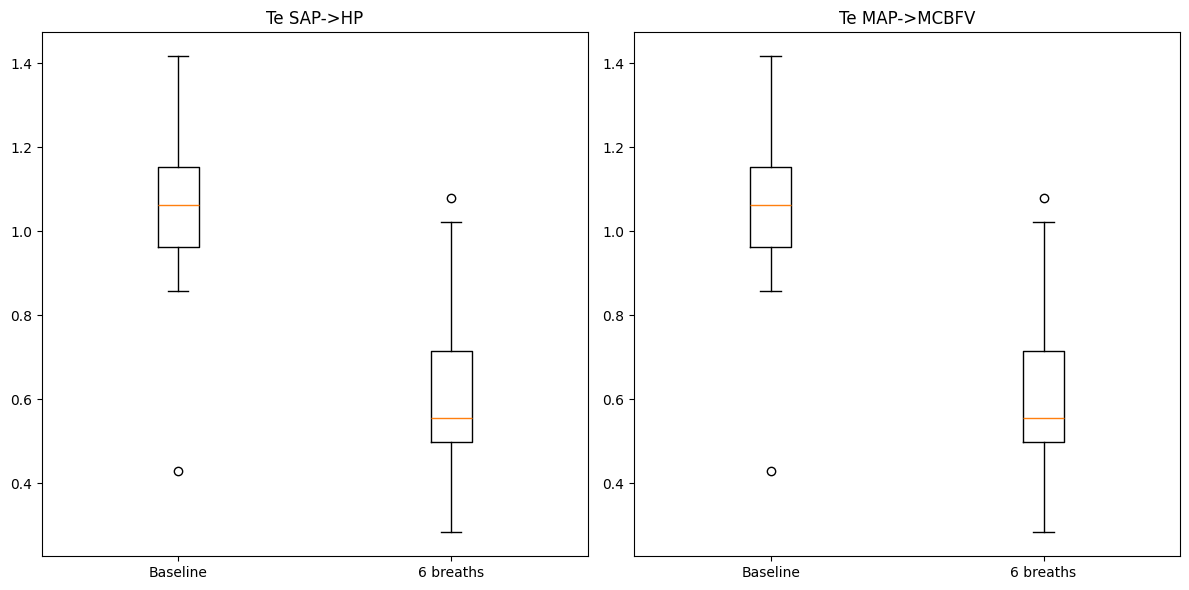

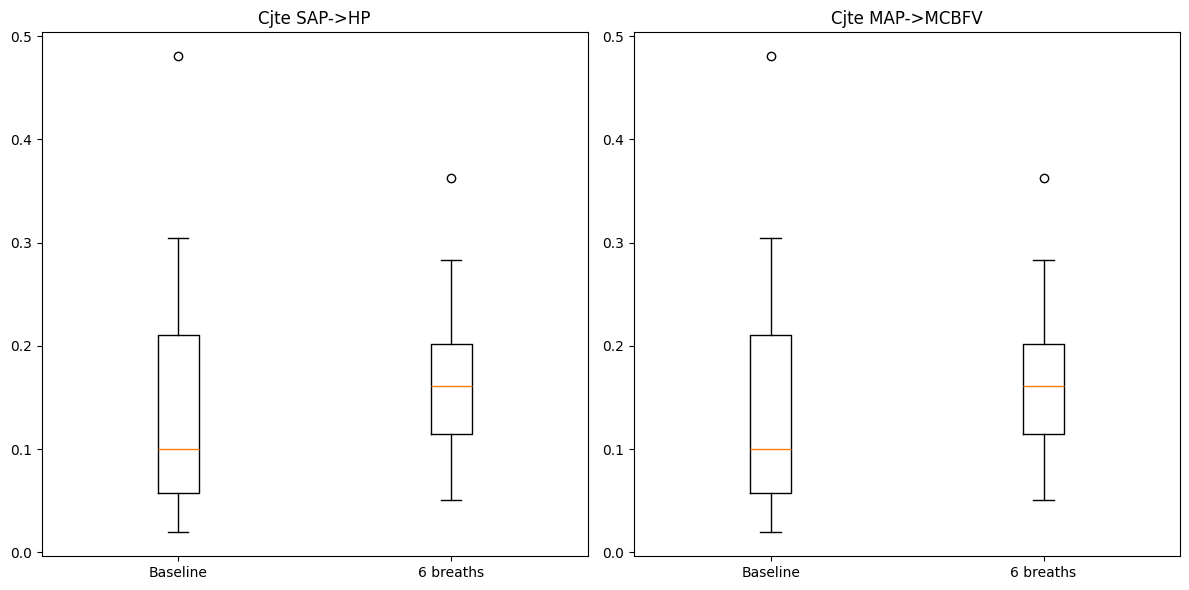

In [62]:
plot_boxplots(df_baseline, df_6breaths)